In [1]:
from util.gen_utils import *
from util.ml_utils import *
from util.plot_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load fitted model and asso attributes
* Fitted model
* Features included in model [in order]
* Train data mask

In [2]:
best_fit = {'model' : read_pkl('out/ml/fitted_model.pkl'),
            'features' : pd.MultiIndex.from_frame(pd.read_csv('out/ml/fitted_model_features.csv'))
           }

all_masks = read_pkl('out/ml/train_data_masks.pkl')
train_mask = all_masks.masks['is_training_and_is_collected_pre17wks']
train_late_mask = np.logical_and(all_masks.masks['is_training_and_not_is_collected_pre17wks'], all_masks.masks['is_training_and_not_is_pp'])

# Load data
* Training data
* Validation RT-qPCR data
* Del Vecchio et al independent data
* Munchel et al S2/S3 independent data

In [3]:
train_all = rnaseq_and_meta_data("../../data/rnaseq_discovery_data/sample_meta_postQC.csv", 
                                 "../../data/rnaseq_discovery_data/htseq_postQC.csv", 
                                 "../../data/rnaseq_discovery_data/TMM_postQC.csv")

train_ml_data = ML_data(rnaseq_meta = train_all.filter_samples(train_mask, inplace = False), y_col = 'case', to_batch_correct = True, group_col = 'subject', features = best_fit['features'], only_gene_name = True)
train_late_ml_data = ML_data(rnaseq_meta = train_all.filter_samples(train_late_mask, inplace = False), y_col = 'case', to_batch_correct = True, group_col = 'subject', features = best_fit['features'], only_gene_name = True)

In [4]:
delvecchio_all = rnaseq_and_meta_data("../../data/delvecchio_data/sample_meta.csv", 
                                 "../../data/delvecchio_data/htseq_merged.csv", 
                                 "../../data/delvecchio_data/TMM.csv",  mL_plasma = 0.2)


#ML data should only contains samples <= 16 weeks which per Del Vecchio et al are T1 samples
delvecchio_all.filter_samples((delvecchio_all.meta.term == 1))
delvecchio_ml_data = ML_data(delvecchio_all, y_col = 'case', to_batch_correct = True, features = best_fit['features'], only_gene_name = True)

#Only PE vs NT
only_pe_v_NT = delvecchio_all.meta.loc[delvecchio_all.meta.complication_during_pregnancy.isin(['No Complications', 'Preeclampsia/gestational hypertension'])].index
delvecchio_ml_data_only_PEvNT = delvecchio_ml_data.filter_samples(only_pe_v_NT)

In [5]:
#Munchel PEARL-PEC and iPEC
munchel_s2 = rnaseq_and_meta_data("../../data/munchel_data/S2_meta.csv", 
                                 "../../data/munchel_data/S2_counts_only.csv", 
                                 "../../data/munchel_data/S2_TMM.csv", counts_index_cols = [0], mL_plasma = 4.5)

munchel_s3 = rnaseq_and_meta_data("../../data/munchel_data/S3_meta.csv", 
                 "../../data/munchel_data/S3_counts_only.csv", 
                 "../../data/munchel_data/S3_TMM.csv", counts_index_cols = [0], mL_plasma = 4.5)

munchel_s2_ml_data = ML_data(munchel_s2, y_col = 'case', to_batch_correct = True, features = best_fit['features'].droplevel('gene_num'))
munchel_s3_ml_data = ML_data(munchel_s3, y_col = 'case', to_batch_correct = True, features = best_fit['features'].droplevel('gene_num'))

In [6]:
pre17wk_samples = {'Discovery' : train_ml_data,
                    'Del Vecchio et al 2020' : delvecchio_ml_data}

late_or_atdiagnosis_samples = {'Discovery' : train_late_ml_data,
                               'Munchel et al 2020 iPEC' : munchel_s2_ml_data,
                               'Munchel et al 2020 PEARL-PEC' : munchel_s3_ml_data}

# Get model performance
* PPV, NPV, Sensitivity, Specificity

In [7]:
#Pre 17 weeks
print('Samples collected at or prior to 16 weeks gestation:')
pre17wk_stats = {dataset_name : get_model_stats(dataset_name, ml_obj, best_fit['model']) for dataset_name, ml_obj in {**pre17wk_samples, **{'Del Vecchio et al 2020 [NT vs PE only]' : delvecchio_ml_data_only_PEvNT}}.items()}

print()
#Late or at diagnosis sample collection
print('Samples collected after 16 weeks gestation or at diagnosis:')
late_or_atdiagnosis_stats = {dataset_name : get_model_stats(dataset_name, ml_obj, best_fit['model']) for dataset_name, ml_obj in late_or_atdiagnosis_samples.items()}

Samples collected at or prior to 16 weeks gestation:
Discovery: Specificity = 100%, Sensitivity = 89%, NPV = 88%, PPV = 100%
Del Vecchio et al 2020: Specificity = 67%, Sensitivity = 100%, NPV = 100%, PPV = 76%
Del Vecchio et al 2020 [NT vs PE only]: Specificity = 89%, Sensitivity = 100%, NPV = 100%, PPV = 88%

Samples collected after 16 weeks gestation or at diagnosis:
Discovery: Specificity = 85%, Sensitivity = 73%, NPV = 73%, PPV = 85%
Munchel et al 2020 iPEC: Specificity = 44%, Sensitivity = 75%, NPV = 68%, PPV = 52%
Munchel et al 2020 PEARL-PEC: Specificity = 62%, Sensitivity = 62%, NPV = 62%, PPV = 62%


# Visualize ROC curve
* Using samples collected at or before 16 weeks gestation (Discovery dataset, Del Vecchio et al 2020)
* Using samples collected at diagnosis (Munchel et al 2020)

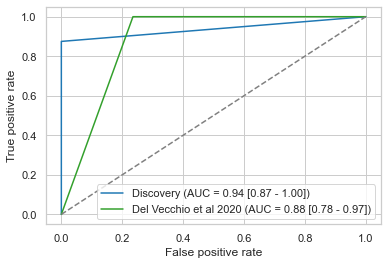

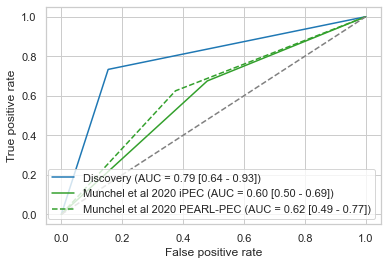

In [8]:
roc_aucs_pre17wk_samples = {key : get_auc_roc_CI(best_fit['model'], data_obj) for key, data_obj in pre17wk_samples.items()}
roc_aucs_late_or_atdiagnosis_samples = {key : get_auc_roc_CI(best_fit['model'], data_obj) for key, data_obj in late_or_atdiagnosis_samples.items()}

plot_roc_curves(roc_aucs_pre17wk_samples, linestyles = ['solid', 'solid'], palette = discovery_test_palette, save_path = 'out/ml/viz/roc_curve_pre17wks.pdf')
plot_roc_curves(roc_aucs_late_or_atdiagnosis_samples, linestyles = ['solid', 'solid', 'dashed'], palette = discovery_test_palette, save_path = 'out/ml/viz/roc_curve_late_or_atdiagnosis.pdf')

# Visualize probability(PE) outputted from model

In [9]:
probPE_pre17wk_samples, X_pre17wk_samples = make_probPE_and_gene_matrix(pre17wk_samples, best_fit['model'])
probPE_late_or_at_diagnosis_samples, _ = make_probPE_and_gene_matrix(late_or_atdiagnosis_samples, best_fit['model'])

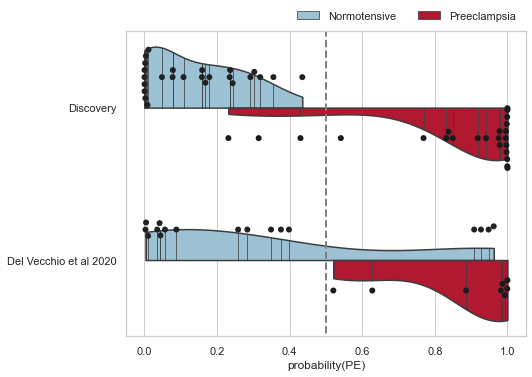

In [10]:
fig, ax = plot_violin_and_swarmplot(probPE_pre17wk_samples, x_name = 'prob_PE', y_name = 'dataset', hue_name = 'case', orient = 'h', violinplot_palette = cntrl_pe_palette,
                                    x_label = 'probability(PE)', y_label = '', split = True, figsize = (7.5, 5), 
                                    include_vline = True, line_pos = 0.5, line_start = -1, line_end = 2) #p(PE) > 0.5 --> classified as at risk

fig.tight_layout()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Normotensive', 'Preeclampsia'], ncol=2, frameon=0, bbox_to_anchor=(1.0, 1.1))
save_figure_pdf(fig, 'out/ml/viz/' + 'probPE_pre17wks.pdf')

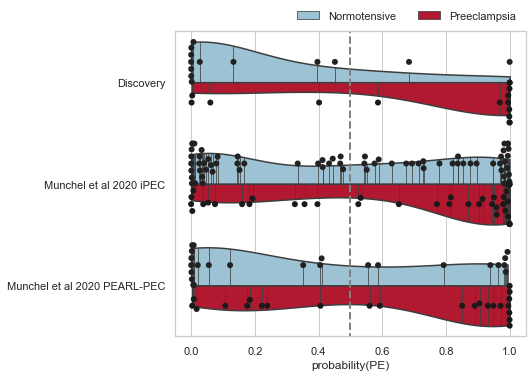

In [11]:
fig, ax = plot_violin_and_swarmplot(probPE_late_or_at_diagnosis_samples, x_name = 'prob_PE', y_name = 'dataset', hue_name = 'case', orient = 'h', violinplot_palette = cntrl_pe_palette,
                                    x_label = 'probability(PE)', y_label = '', split = True, figsize = (7.5, 5), 
                                    include_vline = True, line_pos = 0.5, line_start = -4, line_end = 4)

fig.tight_layout()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Normotensive', 'Preeclampsia'], ncol=2, frameon=0, bbox_to_anchor=(1.0, 1.1))
save_figure_pdf(fig, 'out/ml/viz/' + 'probPE_late_or_at_diagnosis.pdf')

# Visualize model features
* Look at distribution across pre17_wks datasets for genes selected

In [12]:
X_pre17wk_samples_to_plot = X_pre17wk_samples.reset_index().melt(id_vars=['sample', 'dataset', 'case'], var_name = 'gene_name', value_name = 'zc_logCPM').set_index('sample')

#Convenience to specify plot order
ml_genes_ordered = ['BNIP3L', 'FECH', 'HEMGN', 'SNCA', 'OAZ1', 'GSPT1', 'AKNA', 'CSF3R', 'IGF2', 'RPS15', 'MARCH2']
X_pre17wk_samples_to_plot.gene_name = pd.Categorical(X_pre17wk_samples_to_plot.gene_name, ordered = True, 
                                                    categories = ml_genes_ordered)

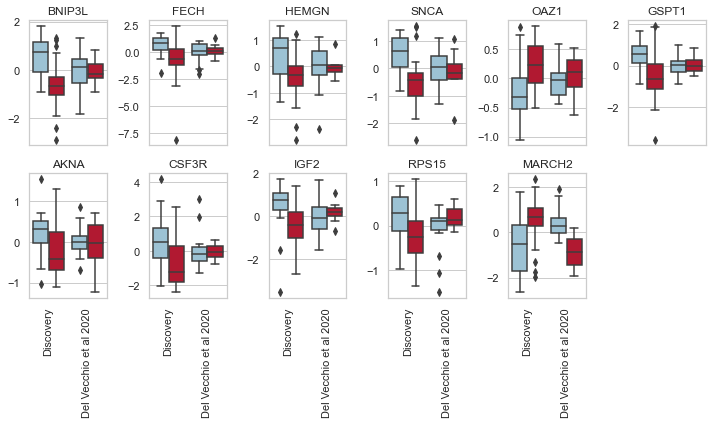

In [13]:
n_genes = len(ml_genes_ordered)

fig, ax = plt.subplots(2, np.ceil(n_genes / 2).astype(int), sharex = True, sharey = False, figsize = (10, 6))
ax_i, ax_j = (0,0)

for gene_name, X_data in X_pre17wk_samples_to_plot.groupby('gene_name'): 
    sns.boxplot('dataset', 'zc_logCPM', hue = 'case', data = X_data, palette = cntrl_pe_palette, ax = ax[ax_i, ax_j]) #inner = 'sticks', split = True, ax = ax[ax_i, ax_j])
    
    ax[ax_i, ax_j].tick_params(axis='x', rotation = 90)
    ax[ax_i, ax_j].set_ylabel('')
    ax[ax_i, ax_j].set_xlabel('')
    ax[ax_i, ax_j].set_title(gene_name)
    ax[ax_i, ax_j].get_legend().remove()
    
    ax_j += 1
    if ax_j == 6:
        ax_i += 1
        ax_j = 0

ax[ax_i, ax_j].set_visible(False)
fig.tight_layout()

save_figure_pdf(fig, 'out/ml/viz/genes_used_in_model.pdf')

In [14]:
#Calculate whether trends observed per gene meet significance
n_ds = len(X_pre17wk_samples_to_plot.dataset.unique())
unadj_pvals = {ds : [] for ds in X_pre17wk_samples_to_plot.dataset.unique()}

#To determine one-sided test direction
logFC_pre17_sig = logFC_data_by_group(best_fit['features'], {True : 'Pre 17 weeks'}, group_col = 'pre17_weeks')
logFC_pre17_sig.get_logFC_and_CI_by_group(train_all.rnaseq.logCPM.loc[best_fit['features'], :], 
                                          train_all.meta.join(train_mask.rename('pre17_weeks')))

for key, X_data in X_pre17wk_samples_to_plot.groupby(['gene_name', 'dataset']):
    gene, dataset = key
    
    #Want to test that Del Vecchio dataset follows same trend across case vs control as discovery so one-sided
    alternative = 'less' if (np.sign(logFC_pre17_sig.logFC.loc[gene]) == -1).iloc[0, 0] else 'greater'
    unadj_pval, _ = test_and_adj([(1, 0)], X_data, 'case', 'zc_logCPM', alternative = alternative, use_ttest = False)
    unadj_pvals[dataset].append(unadj_pval[(1, 0)])
    
to_reject_flat, adj_pval_flat, _, _ = multitest_corr(pd.DataFrame(unadj_pvals).to_numpy().flatten(), method = 'fdr_bh')
to_reject = pd.DataFrame(to_reject_flat.reshape((n_genes, n_ds)), index = ml_genes_ordered, columns = unadj_pvals.keys())
adj_pvals = pd.DataFrame(adj_pval_flat.reshape((n_genes, n_ds)), index = ml_genes_ordered, columns = unadj_pvals.keys())

adj_pvals_full = adj_pvals.merge(to_reject, left_index = True, right_index = True, suffixes = ('', '_is_sig'))
adj_pvals_full

Now calculating logFC for Pre 17 weeks
Now estimating logFC confidence interval for Pre 17 weeks
1000 resampling iterations completed
2000 resampling iterations completed
Identifying when during gestation we observe changes


,Discovery,Del Vecchio et al 2020,Discovery_is_sig,Del Vecchio et al 2020_is_sig
BNIP3L,0.000551,0.455019,True,False
FECH,0.001145,0.653664,True,False
HEMGN,0.004369,0.455019,True,False
SNCA,0.000982,0.455019,True,False
OAZ1,0.003364,0.395640,True,False
GSPT1,0.000822,0.653664,True,False
AKNA,0.014286,0.639628,True,False
CSF3R,0.003364,0.698670,True,False
IGF2,0.000551,0.862616,True,False
RPS15,0.014286,0.913541,True,False
